# Classification de Documents en Arabe avec le Dataset Khaleej

## 📋 Contexte
Nous testons la classification de documents en arabe en utilisant le **dataset Khaleej** avec des modèles linéaires classiques. Cette approche permet d'établir des performances de base avant d'explorer des modèles plus complexes.

## Objectifs
- Évaluer l'efficacité des modèles linéaires sur du texte arabe
- Comparer deux approches linéaires différentes

## 📊 Dataset Khaleej
Le dataset Khaleej contient des articles de presse en arabe catégorisés selon différents thèmes. Caractéristiques principales :
- Langue : Arabe
- Type : Articles journalistiques
- Catégories : Politique, Finance, Sports, Culture, etc.
- Taille : 45,500 documents.

## Modèles Testés

### 1. Logistic Regression
**Description :** Un algorithme fondamental en classification, linéaire et interprétable. Bon point de départ pour comprendre la régression pour la classification.

### 2. Linear SVC 
**Description :** Variante linéaire du SVM, efficace pour les données séparables linéairement.

## Prétraitement du texte arabe

In [1]:
# Biblio
import numpy as np
import pandas as pd
import time
import os
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter # compter les occurrences d'éléments dans une collection

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
class ArabicTextNormalizer:
    
    def __init__(self):
        self.alif_variations = ['أ', 'إ', 'آ', 'ٱ', 'ا']
        self.yae_variations = ['ى', 'ئ', 'ي']
        self.tae_variations = ['ة', 'ه']

        self.arabic_punctuation = '،؛؟ـ«»'
        self.extended_punctuation = self.arabic_punctuation + '!"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'

        
    def normalize_alif(self, text):
        for variation in self.alif_variations[1:]:
            text = text.replace(variation, self.alif_variations[-1])
        return text
    
    def normalize_yae(self, text):
        for variation in self.yae_variations[1:]:
            text = text.replace(variation, self.yae_variations[0])
        return text
    
    def normalize_tae(self, text):
        text = text.replace(self.tae_variations[0], self.tae_variations[1])
        return text
    
    def remove_diacritics(self, text): # diacritics : tashkeel
        diacritics = re.compile('[\u064B-\u065F\u0670]')
        return diacritics.sub('', text)

    def remove_digits(self, text): 
        text = re.sub(r'\d+', ' ', text)
        return text
    
    def normalize_spaces(self, text):
        # Le 'r' devant la chaîne signifie "raw string"
        # \s : n'importe quel caractère d'espacement blanc
        # + : 1 occurrence ou plus du motif précédent
        text = re.sub(r'\s+', ' ', text)
        text = text.strip() # Supprime les espaces au début et à la fin
        return text
    
    def remove_punctuation(self, text):
        return re.sub(f'[{re.escape(self.extended_punctuation)}]', ' ', text) # sub attend un pattern regex
    
    def normalize_text(self, text, 
                      normalize_chars=True,
                      remove_diacritics_flag=True,
                      remove_punct=True, remove_digits=True):
        
        if normalize_chars:
            text = self.normalize_alif(text)
            text = self.normalize_yae(text)
            text = self.normalize_tae(text)
        
        if remove_diacritics_flag:
            text = self.remove_diacritics(text)
        
        if remove_punct:
            text = self.remove_punctuation(text)

        if remove_digits:
            text = self.remove_digits(text)
        
        text = self.normalize_spaces(text)
        
        return text

# 📋 Explication de la Regex `[\u064B-\u065F\u0670]` pour supprimer les Diacritiques Arabes

| Plage/Code | Description |
|------------|-------------|
| `\u064B-\u065F` | Plage de codes Unicode couvrant la plupart des diacritiques arabes |
| `\u0670` | Code spécifique pour d'autres diacritiques |

| Code Unicode | Symbole | Nom | Description |
|--------------|---------|-----|-------------|
| `\u064B` | ﹰ | **Fatḥatān** | Double fatḥa (accusatif indéfini) |
| `\u064C` | ﹲ | **Ḍammatān** | Double ḍamma (nominatif indéfini) |
| `\u064D` | ﹴ | **Kasratān** | Double kasra (génitif indéfini) |
| `\u064E` | ﹶ | **Fatḥa** | Voyelle courte "a" |
| `\u064F` | ﹸ | **Ḍamma** | Voyelle courte "u" |
| `\u0650` | ﹺ | **Kasra** | Voyelle courte "i" |
| `\u0651` | ﹼ | **Shadda** | Redoublement de consonne |
| `\u0652` | ﹾ | **Sukūn** | Absence de voyelle |
| `\u0653` | ﹴ | **Maddah** | Prolongation |
| `\u0654` | ٔ | **Hamza haute** | |
| `\u0655` | ٕ | **Hamza basse** | |
| `\u0670` | ٰ | **Petit alif suscrit** | Alif de prolongation |

## ⚠️ Points Importants à Noter

1. **Les lettres de base ne sont pas affectées** (أ, إ, آ ont des codes Unicode différents)
2. **Cette regex ne couvre pas tous les diacritiques possibles** (comme les signes de récitation coranique avancés)

In [3]:
# Démarrage du chronomètre pour le prétraitement
start_time = time.time()


# ✂️ Tokenisation et Segmentation

# Ressources NLTK 
nltk.download('stopwords')
nltk.download('punkt') # dépendance de base pour le tokenisation
nltk.download('punkt_tab')  # Essentiel pour l'arabe

arabic_stopwords = set(stopwords.words('arabic'))
print(f"\nStopwords arabes: {len(arabic_stopwords)} mots")
print(arabic_stopwords)


Stopwords arabes: 701 mots
{'شين', 'ذي', 'حتى', 'في', 'إياك', 'سوى', 'ثامن', 'الألاء', 'خامس', 'شتانَ', 'مكانكما', 'جير', 'آنفا', 'اللتان', 'جعل', 'جيم', 'أبٌ', 'وما', 'ولو', 'خال', 'ثاء', 'أوّهْ', 'مما', 'ذات', 'أبريل', 'تِي', 'كان', 'اللواتي', 'ميم', 'أين', 'هَيْهات', 'لبيك', 'أربع', 'الذي', 'راح', 'لكيلا', 'ما أفعله', 'عاد', 'تلك', 'ولكن', 'ليستا', 'معاذ', 'كأيّ', 'ثمانين', 'أجل', 'اثني', 'ذوا', 'فإن', 'ولا', 'طاق', 'ثمانون', 'ته', 'التي', 'كأنما', 'حيثما', 'هاء', 'طرا', 'ياء', 'لوما', 'ثلاثون', 'لهم', 'ثمنمئة', 'هيّا', 'إياي', 'اللائي', 'لو', 'خ', 'ا', 'بمن', 'أف', 'سبت', 'نَّ', 'كِخ', 'أل', 'به', 'أخٌ', 'أنى', 'إن', 'إياهن', 'صار', 'فرادى', 'إليكما', 'لها', 'حاء', 'تسعمائة', 'آب', 'ريث', 'د', 'ف', 'تاء', 'حين', 'تشرين', 'ذ', 'هاته', 'كلما', 'نبَّا', 'بماذا', 'ش', 'ذواتي', 'جويلية', 'إياكما', 'شمال', 'لدن', 'إياهما', 'قلما', 'صدقا', 'هناك', 'آها', 'ح', 'أمام', 'أعلم', 'يا', 'ج', 'ساء', 'لمّا', 'مافتئ', 'ليست', 'وهو', 'بس', 'ظنَّ', 'هاتان', 'هذي', 'نعم', 'سقى', 'أولئك', 'إياهم', 'ه

[nltk_data] Downloading package stopwords to C:\Users\SAFAE
[nltk_data]     ERAJI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\SAFAE
[nltk_data]     ERAJI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\SAFAE
[nltk_data]     ERAJI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Exemple :
text = "الكتاب على الطاولة. كيف حالك؟"
sentences = sent_tokenize(text)  # Segmentation en phrases
tokens = []
for s in sentences:
    t = word_tokenize(s)  # Tokenisation de chaque phrase
    tokens.extend(t)      
    
tokens

['الكتاب', 'على', 'الطاولة', '.', 'كيف', 'حالك؟']

In [5]:
class ArabicTokenizer:
    
    def __init__(self):
        self.stop_words = set(stopwords.words('arabic')) 
    
    def tokenize(self, text, remove_stopwords=True):
        # Tokenise le texte en mots
        sentences = sent_tokenize(text)

        all_tokens = []
        for sentence in sentences:
            words = word_tokenize(sentence)
            
            if remove_stopwords:
                words = [word for word in words if word not in self.stop_words]

            words = [str(word) for word in words]
            all_tokens.extend(words)
        
        return all_tokens

**Pourquoi pas de lemmatisation ?**
Parce que les textes journalistiques utilisent déjà un arabe standardisé. Les variations de mots (comme 'يذهب'/'ذهب'/'سيذهب') ont peu d'impact sur la classification - Ainsi TF-IDF capte bien les similarités sans besoin de les réduire à leur racine.

# Dataset

In [6]:
dataset_path = "C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/Khaleej"

normalizer = ArabicTextNormalizer()
tokenizer = ArabicTokenizer()

texts = []
labels = []
label_names = []

print(f"Chargement et prétraitement des données depuis {dataset_path}...")
for i, category in enumerate(os.listdir(dataset_path)): # Parcourir les sous-dossiers (catégories)
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f"  Traitement de la catégorie: {category}")
        for filename in os.listdir(category_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(category_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()

                    # PRETRAITEMENT 
                    normalized_text = normalizer.normalize_text(text)
                    tokens = tokenizer.tokenize(normalized_text) 
                    processed_text = " ".join([str(token) for token in tokens]) # Reconvertir en texte pour TF-IDF
                    
                    texts.append(processed_text) 
                    labels.append(i)
                    label_names.append(category)

print(f"✅ Prétraitement terminé!")
print(f"Nombre total de documents: {len(texts)}")
print(f"Nombre de catégories: {len(set(labels))}")

# Temps de prétraitement
preprocessing_time = time.time() - start_time

print("\n" + "="*60)
print("STATISTIQUES DE TEMPS DE PRÉTRAITEMENT")
print("="*60)
print(f"Temps total de prétraitement: {preprocessing_time:.2f} secondes")
print(f"Temps moyen par document: {preprocessing_time/len(texts):.4f} secondes")
print(f"Nombre de documents traités par seconde: {len(texts)/preprocessing_time:.2f}")
print("="*60)

if texts:
    print(f"\nExemple de texte traité (100 premiers caractères):")
    print(f"{texts[0][:100]}...")

Chargement et prétraitement des données depuis C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/Khaleej...
  Traitement de la catégorie: Culture
  Traitement de la catégorie: Finance
  Traitement de la catégorie: Medical
  Traitement de la catégorie: Politics
  Traitement de la catégorie: Religion
  Traitement de la catégorie: Sports
  Traitement de la catégorie: Tech
✅ Prétraitement terminé!
Nombre total de documents: 45500
Nombre de catégories: 7

STATISTIQUES DE TEMPS DE PRÉTRAITEMENT
Temps total de prétraitement: 128.99 secondes
Temps moyen par document: 0.0028 secondes
Nombre de documents traités par seconde: 352.73

Exemple de texte traité (100 premiers caractères):
ىنظم معهد الشارقه للفنون معرضا فنىا عنوان باقه الفن وذلك الساعه السابعه الىوم فى مقر المعهد فى منطقه...


ANALYSE DES DONNÉES


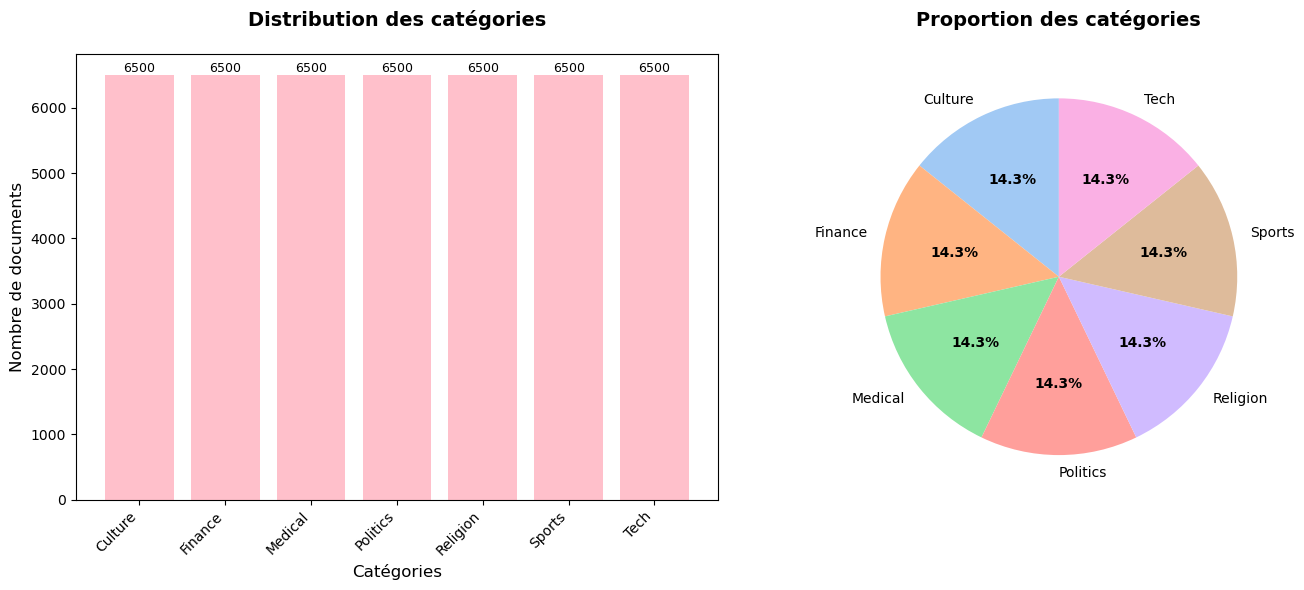

In [7]:
# DataFrame pour faciliter l'analyse
df = pd.DataFrame({
    'text': texts,
    'label': labels,
    'label_name': label_names
})

print("=" * 50)
print("ANALYSE DES DONNÉES")
print("=" * 50)

# Distribution des catégories
plt.figure(figsize=(14, 6))
category_counts = df['label_name'].value_counts()
plt.subplot(1, 2, 1)
bars = plt.bar(range(len(category_counts)), category_counts.values, color='pink')
plt.title('Distribution des catégories', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Catégories', fontsize=12)
plt.ylabel('Nombre de documents', fontsize=12)
plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right', fontsize=10)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)


# bar.get_x() : la position horizontale du début de la barre.
# bar.get_width()/2. : la moitié de la largeur de la barre.
# bar.get_x() + bar.get_width()/2. : donne donc la position centrée de la barre.
# height : c'est la hauteur de la barre (position verticale).
# f'{int(height)}' : affiche la valeur numérique arrondie de la hauteur.

plt.subplot(1, 2, 2)
colors = sns.color_palette("pastel")[:len(category_counts)]

wedges, text_objects, autotexts = plt.pie(category_counts.values, labels=category_counts.index, 
                                    autopct='%1.1f%%', colors=colors, startangle=90) # Graphique camembert
plt.title('Proportion des catégories', fontsize=14, fontweight='bold', pad=20)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

plt.tight_layout()

In [8]:
# Longueur moyenne des textes
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
print(f"\nLongueur moyenne des textes (en mots) : {df['text_length'].mean():.1f}")
print(f"Longueur minimale : {df['text_length'].min()}")
print(f"Longueur maximale : {df['text_length'].max()}")
print(f"Écart-type : {df['text_length'].std():.1f}")


Longueur moyenne des textes (en mots) : 308.9
Longueur minimale : 2
Longueur maximale : 4698
Écart-type : 285.8


In [9]:
print("\n" + "=" * 50)
print("ANALYSE TF-IDF")
print("=" * 50)

vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,  # Ignorer les mots qui apparaissent dans moins de 2 documents
    max_df=0.8,  # Ignorer les mots qui apparaissent dans plus de 80% des documents
    ngram_range=(1, 2)  # Inclure les unigrammes et bigrammes : capture à la fois les mots individuels et les expressions composées de deux mots consécutifs.
)

categories = os.listdir(dataset_path)

tfidf_matrix = vectorizer.fit_transform(df['text'])
feature_names = vectorizer.get_feature_names_out()
    
# DataFrame TF-IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['label_name'] = df['label_name']
    
# Les top mots par catégorie
def get_top_words_by_category(category, n_words=15):
    category_mask = tfidf_df['label_name'] == category
    if not category_mask.any(): # any : si au moins une valeur est True
        return pd.Series([], dtype=float)
    category_tfidf = tfidf_df[category_mask].drop('label_name', axis=1)
    if category_tfidf.shape[0] == 0:
        return pd.Series([], dtype=float)
    # Calcul la moyenne TF-IDF pour chaque mot dans cette catégorie
    word_scores = category_tfidf.mean().sort_values(ascending=False)
    return word_scores.head(n_words) # top 15

for category in categories:
    print(get_top_words_by_category(category))


ANALYSE TF-IDF
التى        0.044381
الشارقه     0.043620
الثقافه     0.033550
العربى      0.032880
الشعر       0.031074
العربىه     0.030912
الذى        0.029678
الثقافىه    0.026468
الكتاب      0.026021
محمد        0.025635
الثقافى     0.025144
المعرض      0.025031
المسرح      0.024500
الامارات    0.024424
الشاعر      0.024088
dtype: float64
ملىون      0.108893
سهم        0.099159
بنسبه      0.096773
بقىمه      0.063758
نقطه       0.051829
شركه       0.046040
سوق        0.045434
دبى        0.044956
ملىار      0.044638
الأسهم     0.041489
بلغت       0.039830
تداول      0.039330
مؤشر       0.039174
المالىه    0.039076
باغلاق     0.036754
dtype: float64
الصحىه            0.059291
الصحه             0.052420
الطبىه            0.050848
دبى               0.037034
أبوظبى            0.034364
مستشفى            0.032086
التى              0.027893
المستشفى          0.026924
الصحى             0.026575
الرعاىه           0.025519
الدكتور           0.025131
خلال              0.022311
المرضى         

In [11]:
print("\n" + "=" * 50)
print("ANALYSE DES FRÉQUENCES BRUTES")
print("=" * 50)

for category in categories:
    print(f"\n📈 {category} - Mots les plus fréquents :")
    
    # Combine tous les textes de la catégorie
    all_words = []
    category_docs = df[df['label_name'] == category]['text']
    
    if len(category_docs) == 0:
        print("Aucun document dans cette catégorie")
        continue
        
    for text in category_docs:
        words = str(text).split()
        all_words.extend(words)
    
    if len(all_words) == 0:
        print("Aucun mot dans les documents de cette catégorie")
        continue

    word_freq = Counter(all_words)
    most_common = word_freq.most_common(15)
    
    total_words = len(all_words)
    for word, freq in most_common:
        percentage = (freq / total_words) * 100
        print(f"  {word}: {freq} occurrences ({percentage:.1f}%)")


ANALYSE DES FRÉQUENCES BRUTES

📈 Culture - Mots les plus fréquents :
  فى: 85517 occurrences (4.4%)
  الى: 24470 occurrences (1.3%)
  التى: 19357 occurrences (1.0%)
  الذى: 11668 occurrences (0.6%)
  الشارقه: 8178 occurrences (0.4%)
  العربىه: 7000 occurrences (0.4%)
  بىن: 6873 occurrences (0.4%)
  العربى: 6435 occurrences (0.3%)
  الامارات: 6319 occurrences (0.3%)
  محمد: 6306 occurrences (0.3%)
  خلال: 6072 occurrences (0.3%)
  الثقافه: 5754 occurrences (0.3%)
  حىث: 5369 occurrences (0.3%)
  بن: 5310 occurrences (0.3%)
  ان: 5093 occurrences (0.3%)

📈 Finance - Mots les plus fréquents :
  فى: 49972 occurrences (3.5%)
  ملىون: 30836 occurrences (2.2%)
  الى: 26270 occurrences (1.9%)
  بنسبه: 25235 occurrences (1.8%)
  سهم: 24028 occurrences (1.7%)
  بقىمه: 16123 occurrences (1.1%)
  دبى: 13918 occurrences (1.0%)
  نقطه: 13573 occurrences (1.0%)
  خلال: 13527 occurrences (1.0%)
  شركه: 12193 occurrences (0.9%)
  سوق: 11216 occurrences (0.8%)
  حىث: 10511 occurrences (0.7%)
  ملىار: 


STATISTIQUES AVANCÉES

📚 Taille du vocabulaire par catégorie :
Catégorie  Documents  Mots totaux  Mots uniques Densité lexicale
  Culture       6500      1946700        146842            0.075
  Finance       6500      1419247         40326            0.028
  Medical       6500      1416818         68431            0.048
 Politics       6500      1328724         93440            0.070
 Religion       6500      4386485        276266            0.063
   Sports       6500      1613709         90518            0.056
     Tech       6500      1944012         86473            0.044


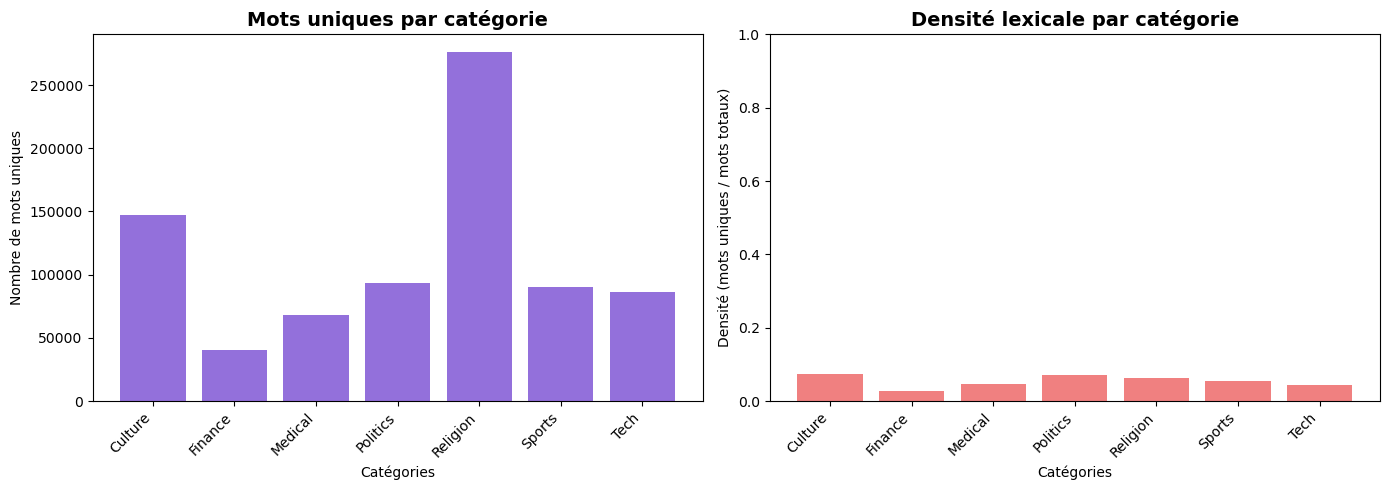

In [12]:
print("\n" + "=" * 50)
print("STATISTIQUES AVANCÉES")
print("=" * 50)

# Vocabulaire unique par catégorie
print("\n📚 Taille du vocabulaire par catégorie :")
vocab_stats = []
for category in categories:
    all_words = []
    for text in df[df['label_name'] == category]['text']:
        words = str(text).split()
        all_words.extend(words)
    
    if all_words:
        unique_words = set(all_words)
        vocab_stats.append({
            'Catégorie': category,
            'Documents': len(df[df['label_name'] == category]),
            'Mots totaux': len(all_words),
            'Mots uniques': len(unique_words),
            'Densité lexicale': f"{len(unique_words)/len(all_words):.3f}" if len(all_words) > 0 else "N/A"
        })
    else:
        vocab_stats.append({
            'Catégorie': category,
            'Documents': len(df[df['label_name'] == category]),
            'Mots totaux': 0,
            'Mots uniques': 0,
            'Densité lexicale': "N/A"
        })

# Statistiques sous forme de tableau
vocab_df = pd.DataFrame(vocab_stats)
print(vocab_df.to_string(index=False))

if len(vocab_stats) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graphique des mots uniques
    axes[0].bar(range(len(vocab_stats)), [s['Mots uniques'] for s in vocab_stats], 
                color='mediumpurple')
    axes[0].set_title('Mots uniques par catégorie', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Catégories')
    axes[0].set_ylabel('Nombre de mots uniques')
    axes[0].set_xticks(range(len(vocab_stats)))
    axes[0].set_xticklabels([s['Catégorie'] for s in vocab_stats], rotation=45, ha='right')

    
    densities = [] # Densité lexicale = Rapport entre mots uniques et total des mots dans un texte.
    categories_for_density = []
    for s in vocab_stats:
        if s['Densité lexicale'] != "N/A":
            densities.append(float(s['Densité lexicale']))
            categories_for_density.append(s['Catégorie'])
    
    if densities:
        axes[1].bar(range(len(densities)), densities, color='lightcoral')
        axes[1].set_title('Densité lexicale par catégorie', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Catégories')
        axes[1].set_ylabel('Densité (mots uniques / mots totaux)')
        axes[1].set_xticks(range(len(densities)))
        axes[1].set_xticklabels(categories_for_density, rotation=45, ha='right')
        axes[1].set_ylim([0, 1])
    
    plt.tight_layout()

In [13]:
X = vectorizer.fit_transform(texts)
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Nombre de features: {X_train.shape[1]}")
print(f"Nombre de classes: {len(np.unique(y_train))}")

Train shape: (36400, 10000)
Test shape: (9100, 10000)
Nombre de features: 10000
Nombre de classes: 7


# Modélisation

## 1. Régression Logistique

In [14]:
print("\n🔧 ENTRAÎNEMENT DU MODÈLE REGRESSION LOGISTIQUE...")
print("-" * 40)

start_time = time.time()
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
logreg_train_time = time.time() - start_time

y_pred_logreg = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, y_pred_logreg)

print(f"Entraînement terminé en {logreg_train_time:.2f} secondes")
print(f"Accuracy: {logreg_acc:.4f}")


🔧 ENTRAÎNEMENT DU MODÈLE REGRESSION LOGISTIQUE...
----------------------------------------
Entraînement terminé en 11.95 secondes
Accuracy: 0.9768


## 2. SVC Linéaire

In [15]:
print("\n🔧 ENTRAÎNEMENT DU MODÈLE BASELINE...")
print("-" * 40)

start_time = time.time()
svc = LinearSVC(random_state=42, max_iter=1000)
svc.fit(X_train, y_train)
svc_train_time = time.time() - start_time

y_pred_svc = svc.predict(X_test)
svc_acc = accuracy_score(y_test, y_pred_svc)

print(f"Entraînement terminé en {svc_train_time:.2f} secondes")
print(f"Accuracy: {svc_acc:.4f}")


🔧 ENTRAÎNEMENT DU MODÈLE BASELINE...
----------------------------------------
Entraînement terminé en 11.07 secondes
Accuracy: 0.9784


In [16]:
print("\n" + "=" * 50)
print("COMPARAISON DES MODÈLES")
print("=" * 50)

def calculate_metrics(y_true, y_pred, model_name, train_time, search_time=None):
    metrics = {
        'Modèle': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro'),
        'F1-Score (macro)': f1_score(y_true, y_pred, average='macro'),
        'Temps entraînement (s)': train_time
    }
    
    if search_time:
        metrics['Temps recherche (s)'] = search_time
        metrics['Temps total (s)'] = train_time + search_time
    
    return metrics

# Métriques pour tous les modèles
metrics_data = [
    calculate_metrics(y_test, y_pred_logreg, 'Logistic Regression', logreg_train_time),
    calculate_metrics(y_test, y_pred_svc, 'SVC', svc_train_time)
]


metrics_df = pd.DataFrame(metrics_data)

print("\n📊 TABLEAU COMPARATIF DES PERFORMANCES:")
print("-" * 60)
print(metrics_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))

print("\n⏱️ ANALYSE DES TEMPS D'APPRENTISSAGE:")
print("-" * 40)

print("Logistic Regression:")
print(f"{logreg_train_time:.2f}s")

print("\nLinear SVC:")
print(f"{svc_train_time:.2f}s")


COMPARAISON DES MODÈLES

📊 TABLEAU COMPARATIF DES PERFORMANCES:
------------------------------------------------------------
             Modèle  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)  Temps entraînement (s)
Logistic Regression    0.9768             0.9769          0.9768            0.9768                 11.9511
                SVC    0.9784             0.9784          0.9784            0.9784                 11.0655

⏱️ ANALYSE DES TEMPS D'APPRENTISSAGE:
----------------------------------------
Logistic Regression:
11.95s

Linear SVC:
11.07s


## 4. Sauvegarde

In [17]:
print("💾 SAUVEGARDE DES MEILLEURS MODÈLES ET DES STATISTIQUES...")

joblib.dump(vectorizer, 'C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/vectorizer/tfidf_vectorizer.pkl')
print("Vectorizer TF-IDF sauvegardé")

performance_metrics = {
    'logreg_baseline': {
        'accuracy': logreg_acc,
        'train_time': logreg_train_time
    },
    'svc_baseline': {
        'accuracy': svc_acc,
        'train_time': svc_train_time
    }
}

print("✅ Les modèles ont été sauvegardés")

💾 SAUVEGARDE DES MEILLEURS MODÈLES ET DES STATISTIQUES...
Vectorizer TF-IDF sauvegardé
✅ Les modèles ont été sauvegardés


## 5. Visualisation


VISUALISATION DES RÉSULTATS


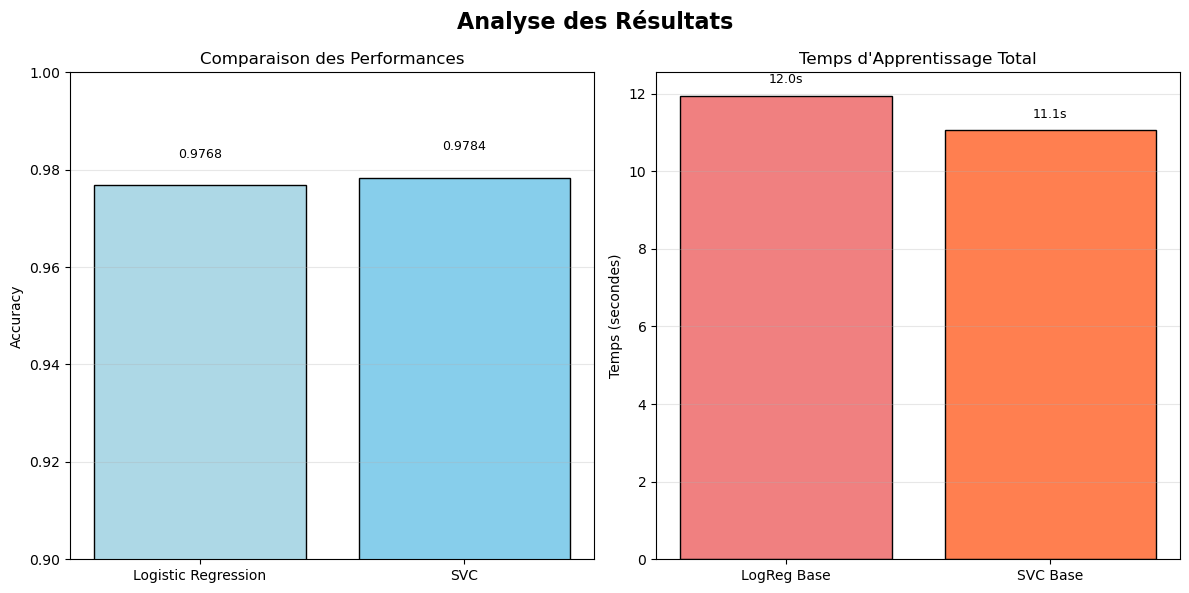

In [18]:
print("\n" + "=" * 50)
print("VISUALISATION DES RÉSULTATS")
print("=" * 50)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Analyse des Résultats', fontsize=16, fontweight='bold')

# 1. Comparaison des performances (Accuracy)
axes[0].bar(['Logistic Regression', 'SVC'],
               [logreg_acc, svc_acc],
               color=['lightblue', 'skyblue'],
               edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Comparaison des Performances')
axes[0].set_ylim([0.9, 1.0])
axes[0].grid(True, axis='y', alpha=0.3)

for i, acc in enumerate([logreg_acc, svc_acc]):
    axes[0].text(i, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Temps d'apprentissage
models_time = ['LogReg Base', 'SVC Base']
train_times = [logreg_train_time, svc_train_time]

bars = axes[1].bar(models_time, train_times,
                      color=['lightcoral', 'coral'],
                      edgecolor='black')
axes[1].set_ylabel('Temps (secondes)')
axes[1].set_title('Temps d\'Apprentissage Total')
axes[1].grid(True, axis='y', alpha=0.3)

for bar, t in zip(bars, train_times):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + max(train_times)*0.02,
                   f'{t:.1f}s', ha='center', va='bottom', fontsize=9)


plt.tight_layout()

In [19]:
print("\n" + "=" * 60)
print("📊 RÉSUMÉ FINAL DE L'OPTIMISATION")
print("=" * 60)

summary_df = pd.DataFrame({
    'Modèle': ['Logistic Regression', 'SVC'],
    'Accuracy': [logreg_acc, svc_acc],
    'Temps entraînement (s)': [logreg_train_time,
                               svc_train_time]
})

print(summary_df.to_string(index=False, float_format=lambda x: f'{x:.2f}' if isinstance(x, float) else str(x)))


📊 RÉSUMÉ FINAL DE L'OPTIMISATION
             Modèle  Accuracy  Temps entraînement (s)
Logistic Regression      0.98                   11.95
                SVC      0.98                   11.07


In [20]:
def plot_confusion_matrix(y_true, y_pred, model_name, labels, figsize=(12, 10)):
    cm = confusion_matrix(y_true, y_pred)

    fig.suptitle(f'Matrice de Confusion - {model_name}', fontsize=16, fontweight='bold')
    
    # 1. Matrice brute
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
                xticklabels=labels, yticklabels=labels)
    plt.title('', fontsize=14)
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies étiquettes', fontsize=12)

    return cm

unique_labels = sorted(set(label_names))

array([[1264,    0,    1,    6,   23,    1,    5],
       [   1, 1278,    1,    4,    0,    0,   16],
       [   2,    2, 1278,    4,    4,    0,   10],
       [   2,    1,   10, 1277,    6,    2,    2],
       [  31,    0,    9,   12, 1243,    1,    4],
       [   1,    2,    0,   15,    0, 1281,    1],
       [   6,   12,   12,    1,    1,    0, 1268]], dtype=int64)

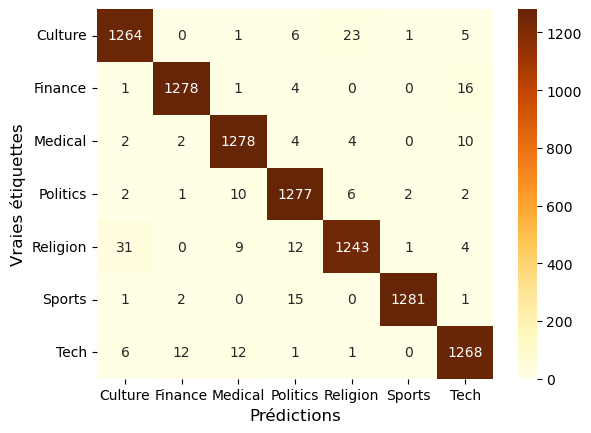

In [21]:
# Logistic Regression
plot_confusion_matrix(y_test, y_pred_logreg, logreg, unique_labels, figsize=(12, 10))

array([[1259,    0,    1,    6,   25,    4,    5],
       [   1, 1283,    0,    3,    1,    0,   12],
       [   3,    3, 1281,    4,    2,    0,    7],
       [   3,    0,    8, 1278,    8,    2,    1],
       [  29,    0,    5,   11, 1252,    1,    2],
       [   1,    1,    1,   14,    0, 1282,    1],
       [   4,   14,   13,    1,    0,    0, 1268]], dtype=int64)

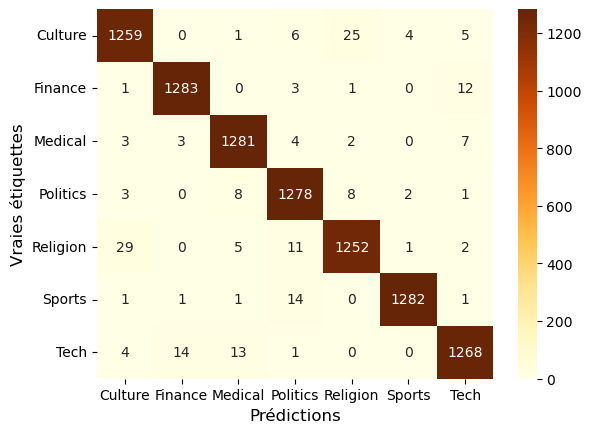

In [22]:
# SVC
plot_confusion_matrix(y_test, y_pred_svc, svc, unique_labels, figsize=(12, 10))

In [ ]:
# interface (model et vectorizer)
# un seul fichier de pretraitement

# ajouter les visualisations
# nuage de mots mot plus frequents
# projet dans linkedin avec contributeurs
# deployment sur heroku ou autre
# github
# un bon readme avec screenshots pour github